# NNCL ASSIGNMENT 3

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/5p/j2sf71mn1csfx38_374kdnz80000gn/T/ipykernel_18029/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Neural Network

In [82]:
class Network:
    def __init__(self, P, Q, N, K, learning_rate):
        self.P = P  # Number of input samples
        self.Q = Q  # Number of test samples
        self.N = N  # Number of neurons in the input layer
        self.K = K  # Number of neurons in the hidden layer
        self.eta = learning_rate  # Learning rate for the neural network
        self.prev_weights = []  # Previous weights for the hidden layer
        self.W = self.initWeights()  # Weights from input layer to hidden layer
        self.V = np.ones(
            (1, self.K)
        )  # Weights from hidden layer to output layer, initialized to 1

    def initWeights(self):
        """
        This function initializes the weights of the neural network.
        """
        # Generate random weights for each neuron in the hidden layer
        weights = np.random.randn(self.N, self.K)

        # Calculate the squared norm (length) of each weight vector
        norms_squared = np.linalg.norm(weights, axis=1, keepdims=True) ** 2

        # Normalize each weight vector to have a length of 1
        normalized_weights = weights / norms_squared

        # Store the initial weights
        self.prev_weights.append(normalized_weights.copy())

        return normalized_weights

    def forwardPass(self, x):
        """
        This function performs the forward pass of a neural network with a single hidden layer.
        It uses the tanh activation function for the hidden layer neurons.
        """
        # Calculate the dot product of the input vector 'x' and the transpose of the weight matrix 'W' of the first layer.
        dot_product = np.dot(self.W.T, x)

        # Apply the hyperbolic tangent function element-wise to the result of the dot product.
        tanh_result = np.tanh(dot_product)

        # Calculate the output of the network ('sigma') by multiplying the output weights 'V' with the tanh_result and summing the result.
        sigma = np.sum(self.V * tanh_result)

        # Return the output of the network for the given input 'x'.
        return sigma

    def stochasticGradientDescent(self, sigma, xi, tau, t):
        """
        This function performs the stochastic gradient descent optimization algorithm.
        It updates the weights of the network based on the error of the network's output.
        """
        # Iterate over each neuron in the hidden layer
        for i in range(self.K):
            # Compute the gradient of the error with respect to the weights
            gradient = (sigma - tau) * (1 - np.tanh(np.dot(self.W[:, i], xi)) ** 2)
            # Calculate the learning rate for the current epoch
            learning_rate = self.eta(t) if callable(self.eta) else self.eta
            # Update the weights by subtracting the product of the learning rate, the gradient, and the input
            self.W[:, i] -= learning_rate * gradient * xi

    def calculateError(self, sigma, tau):
        """
        This function calculates the error of the neural network's output.
        The error is defined as the half of the squared difference between the network's output (sigma) and the target value (tau).
        """
        # Compute the error
        return ((sigma - tau) ** 2) / 2

    def train(self, t_max, train_set, test_set, verbose=True):
        """
        Train the network using stochastic gradient descent.
        """
        # Initialize lists to store training and testing errors
        train_err = []
        test_err = []

        # Run the training for t_max epochs
        for epoch in range(t_max):
            # Initialize error trackers for the current epoch
            epoch_error = 0
            epoch_error_test = 0

            # For each training sample in a random order
            for index in np.random.permutation(self.P):
                xi, tau = train_set[index]  # Get input and target output
                sigma = self.forwardPass(xi)  # Perform forward pass
                epoch_error += self.calculateError(
                    sigma, tau
                )  # Calculate and accumulate error
                self.stochasticGradientDescent(
                    sigma, xi, tau, epoch
                )  # Update weights using SGD

            self.prev_weights.append(self.W.copy())  # Store the previous weights

            # Calculate average training error for the epoch
            epoch_error /= self.P

            # For each testing sample in a random order
            for index in np.random.permutation(self.Q):
                xi, tau = test_set[index]  # Get input and target output
                sigma = self.forwardPass(xi)  # Perform forward pass
                epoch_error_test += self.calculateError(
                    sigma, tau
                )  # Calculate and accumulate error

            # Calculate average testing error for the epoch
            epoch_error_test /= self.Q

            # Store the average errors for this epoch
            train_err.append(epoch_error)
            test_err.append(epoch_error_test)

            if verbose:
                # Print the average errors for this epoch
                print(
                    f"Epoch: {epoch}, Error: {epoch_error.item()}, Test Error: {epoch_error_test.item()}"
                )

        # Return the list of average training and testing errors for each epoch
        return train_err, test_err, self.prev_weights

## Load dataset

In [5]:
# Load input data from CSV file
xi = pd.read_csv("data/xi.csv", delimiter=",", header=None)

# Load target output data from CSV file
tau = pd.read_csv("data/tau.csv", delimiter=",", header=None)

# Combine input and target output data into a dataset of (input, target) pairs
dataset = [(xi.iloc[:, i], tau.iloc[:, i][0]) for i in range(5000)]

## Run Networks

In [91]:
# Define network parameters
P = 600  # Number of training samples
Q = 200  # Number of testing samples
N = 50   # Input dimensionality
K = 2    # Number of neurons in the hidden layer

# Split dataset into training and testing sets
train_set = dataset[:P]
test_set = dataset[P:P+Q]

# Initialize network with specified parameters and learning rate
network = Network(P=P, Q=Q, N=N, K=K, learning_rate=0.05)

# Train the network and retrieve training and testing errors
train_err, test_err, weights = network.train(t_max=100, train_set=train_set, test_set=test_set)

Epoch: 0, Error: 0.7644930069851851, Test Error: 0.6625118189317654
Epoch: 1, Error: 0.4091798196076411, Test Error: 0.41277284791582936
Epoch: 2, Error: 0.25877091842639954, Test Error: 0.27356129882859054
Epoch: 3, Error: 0.17229932148928526, Test Error: 0.17334772843996718
Epoch: 4, Error: 0.12464053473979336, Test Error: 0.17906427076198259
Epoch: 5, Error: 0.10326092015700965, Test Error: 0.1513050022043896
Epoch: 6, Error: 0.09666862193993926, Test Error: 0.13683930798579305
Epoch: 7, Error: 0.08969942310744358, Test Error: 0.13498187953857207
Epoch: 8, Error: 0.08558780701794283, Test Error: 0.1320500733085591
Epoch: 9, Error: 0.08531018800280774, Test Error: 0.1436356338469425
Epoch: 10, Error: 0.08753465761064437, Test Error: 0.13127363229095493
Epoch: 11, Error: 0.08442679549915584, Test Error: 0.12805059331449314
Epoch: 12, Error: 0.08426042263062694, Test Error: 0.11872549433046826
Epoch: 13, Error: 0.08233611273312445, Test Error: 0.1153812995166435
Epoch: 14, Error: 0.083

## Plot the Results

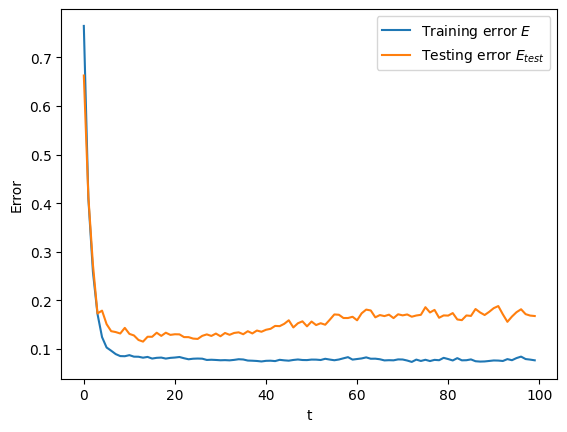

Minimum testing error: 0.1153812995166435
Index of minimum testing error: 13


In [101]:
# Plot the training and testing errors over epochs
plt.plot(train_err, label=r'Training error $E$')
plt.plot(test_err, label=r'Testing error $E_{test}$')

# Add a legend to the plot
plt.legend()

# Add labels to the x and y axes
plt.xlabel('t')
plt.ylabel('Error')

# Display the plot
plt.show()

# Print minimum testing error
print(f"Minimum testing error: {min(test_err)}")
# Print index of minimum testing error
print(f"Index of minimum testing error: {test_err.index(min(test_err))}")

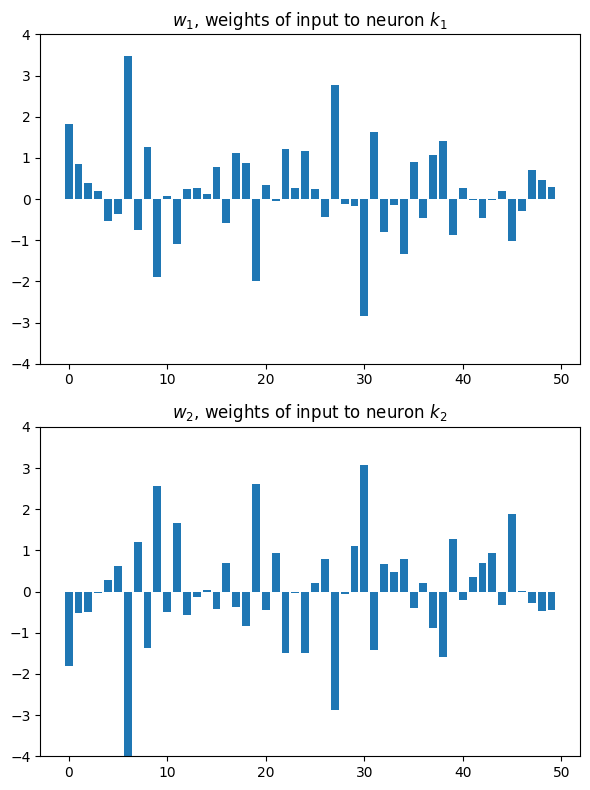

In [129]:
# Plot the weights of the hidden layer neurons at index 40 and index 50 as two separate subplots as bar plots, with the bars tightly packed together
plt.figure(figsize=(6, 8))  # Adjust the figure size

plt.subplot(2, 1, 1)  # Change subplot arrangement to 2 rows and 1 column
plt.bar(np.arange(len(weights[100][:, 0])), weights[100][:, 0])
plt.title(r'$w_1$, weights of input to neuron $k_1$')
plt.ylim(-4, 4)

plt.subplot(2, 1, 2)  # Change subplot arrangement to 2 rows and 1 column
plt.bar(np.arange(len(weights[100][:, 1])), weights[100][:, 1])
plt.title(r'$w_2$, weights of input to neuron $k_2$')
plt.ylim(-4, 4)

# Display the plot
plt.tight_layout()
plt.show()

## Variations of P

In [144]:
# Define network parameters
P_values = [20, 50, 200, 500, 1000, 2000]  # Number of training samples
N = 50   # Input dimensionality
K = 2    # Number of neurons in the hidden layer

# Store results
results = []

for i, P in enumerate(P_values):
    print(f"Running experiment with P = {P}...")
    Q = P // 2  # Number of testing samples

    # Split dataset into training and testing sets
    train_set = dataset[:P]
    test_set = dataset[P:P+Q]

    # Initialize network with specified parameters and learning rate
    network = Network(P=P, Q=Q, N=N, K=K, learning_rate=0.05)

    # Train the network and retrieve training and testing errors
    train_err, test_err, weights = network.train(t_max=100, train_set=train_set, test_set=test_set, verbose=False)

    # Store results
    results.append((train_err, test_err, weights))

Running experiment with P = 20...
Running experiment with P = 50...
Running experiment with P = 200...
Running experiment with P = 500...
Running experiment with P = 1000...
Running experiment with P = 2000...


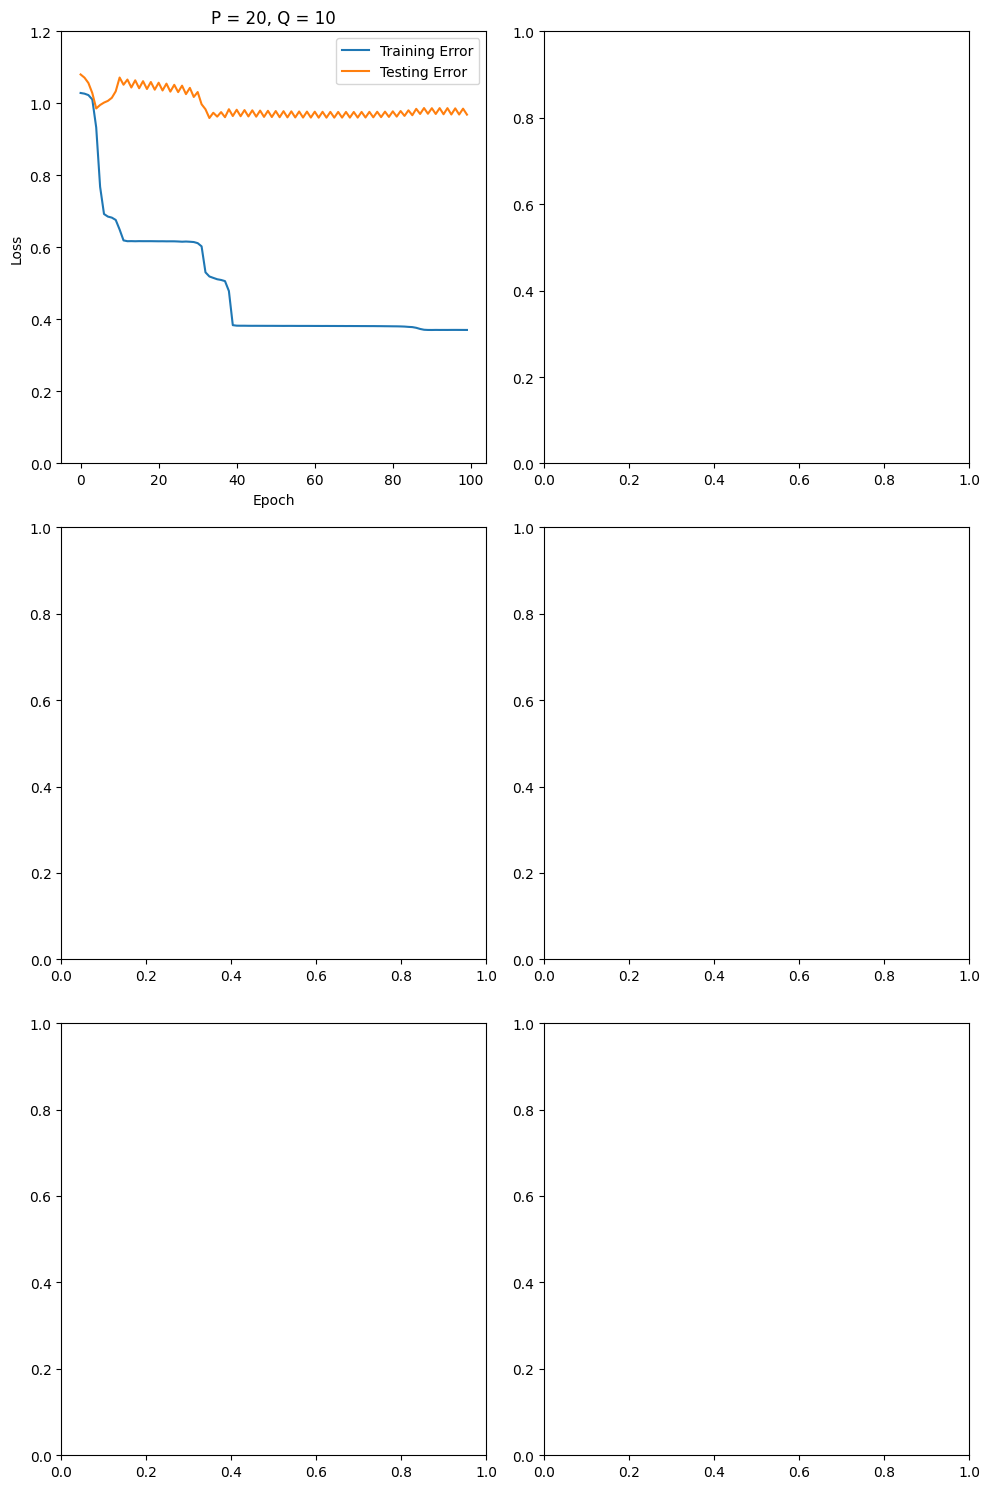

In [143]:
# Create plots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for i, (train_err, test_err, weights) in enumerate(results):
    # Set all y axis limits to the same value
    axs[i//2, i%2].set_ylim(0, 1.2)

    # Plot the training and testing errors over epochs
    axs[i//2, i%2].plot(train_err, label="Training Error")
    axs[i//2, i%2].plot(test_err, label="Testing Error")

    # Add a legend to the plot
    axs[i//2, i%2].legend()

    # Add labels to the x and y axes
    axs[i//2, i%2].set_xlabel('Epoch')
    axs[i//2, i%2].set_ylabel('Loss')
    axs[i//2, i%2].set_title(f'P = {P_values[i]}, Q = {P_values[i] // 2}')

# Display the plot
plt.tight_layout()
plt.show()

## Variations of K

In [145]:
# Define network parameters
P = 600  # Number of training samples
Q = 200  # Number of testing samples
N = 50   # Input dimensionality
K_values = [2, 4, 8, 16]    # Number of neurons in the hidden layer

fig, axs = plt.subplots(2, 2, figsize=(10, 15))

for i, K in enumerate(K_values):
    print(f"Running experiment with K = {K}...")
    # Split dataset into training and testing sets
    train_set = dataset[:P]
    test_set = dataset[P:P+Q]

    # Initialize network with specified parameters and learning rate
    network = Network(P=P, Q=Q, N=N, K=K, learning_rate=0.05)

    # Train the network and retrieve training and testing errors
    train_err, test_err, weights = network.train(t_max=100, train_set=train_set, test_set=test_set, verbose=False)

    # Set all y axis limits to the same value
    # axs[i//2, i%2].set_ylim(0, 1.2)

    # Plot the training and testing errors over epochs
    axs[i//2, i%2].plot(train_err, label="Training Error")
    axs[i//2, i%2].plot(test_err, label="Testing Error")

    # Add a legend to the plot
    axs[i//2, i%2].legend()

    # Add labels to the x and y axes
    axs[i//2, i%2].set_xlabel('Epoch')
    axs[i//2, i%2].set_ylabel('Loss')
    axs[i//2, i%2].set_title(f'P = {P}, Q = {Q}')

# Display the plot
plt.tight_layout()
plt.show()

Running experiment with K = 2...
Running experiment with K = 4...


## Variations of learning rate

Running experiment with learning rate = 0.01...
Running experiment with learning rate = 0.05...
Running experiment with learning rate = 0.2...
Running experiment with learning rate = 1...
Running experiment with learning rate = 2...
Running experiment with learning rate = 4...


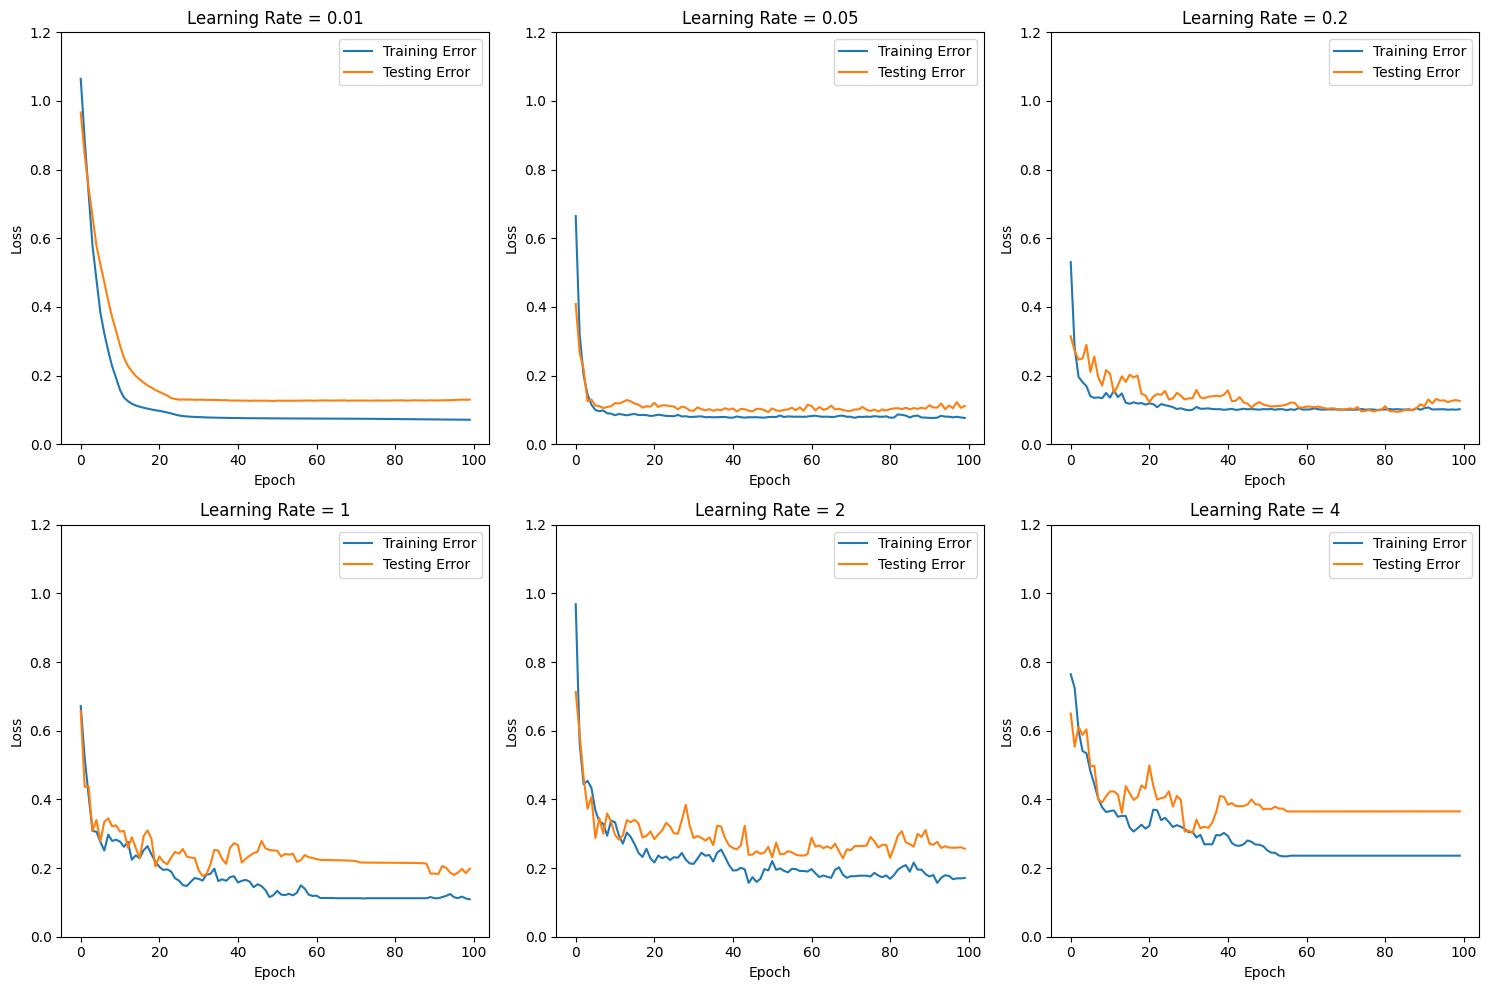

In [17]:
# Define network parameters
learning_rates = [0.01, 0.05, 0.2, 1, 2, 4]  # Learning rates to test
P = 600  # Number of training samples
Q = 200  # Number of testing samples
N = 50   # Input dimensionality
K = 2    # Number of neurons in the hidden layer

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, learning_rate in enumerate(learning_rates):
    print(f"Running experiment with learning rate = {learning_rate}...")

    # Initialize network with specified parameters and learning rate
    network = Network(P=P, Q=Q, N=N, K=K, learning_rate=learning_rate)

    # Train the network and retrieve training and testing errors
    train_err, test_err, weights = network.train(t_max=100, train_set=train_set, test_set=test_set, verbose=False)

    # Set all y axis limits to the same value
    axs[i//3, i%3].set_ylim(0, 1.2)

    # Plot the training and testing errors over epochs
    axs[i//3, i%3].plot(train_err, label="Training Error")
    axs[i//3, i%3].plot(test_err, label="Testing Error")

    # Add a legend to the plot
    axs[i//3, i%3].legend()

    # Add labels to the x and y axes
    axs[i//3, i%3].set_xlabel('Epoch')
    axs[i//3, i%3].set_ylabel('Loss')
    axs[i//3, i%3].set_title(f'Learning Rate = {learning_rate}')

# Display the plot
plt.tight_layout()
plt.show()

### Variable learning rate, time dependent

Running experiment with learning rate function 1...
Running experiment with learning rate function 2...
Running experiment with learning rate function 3...


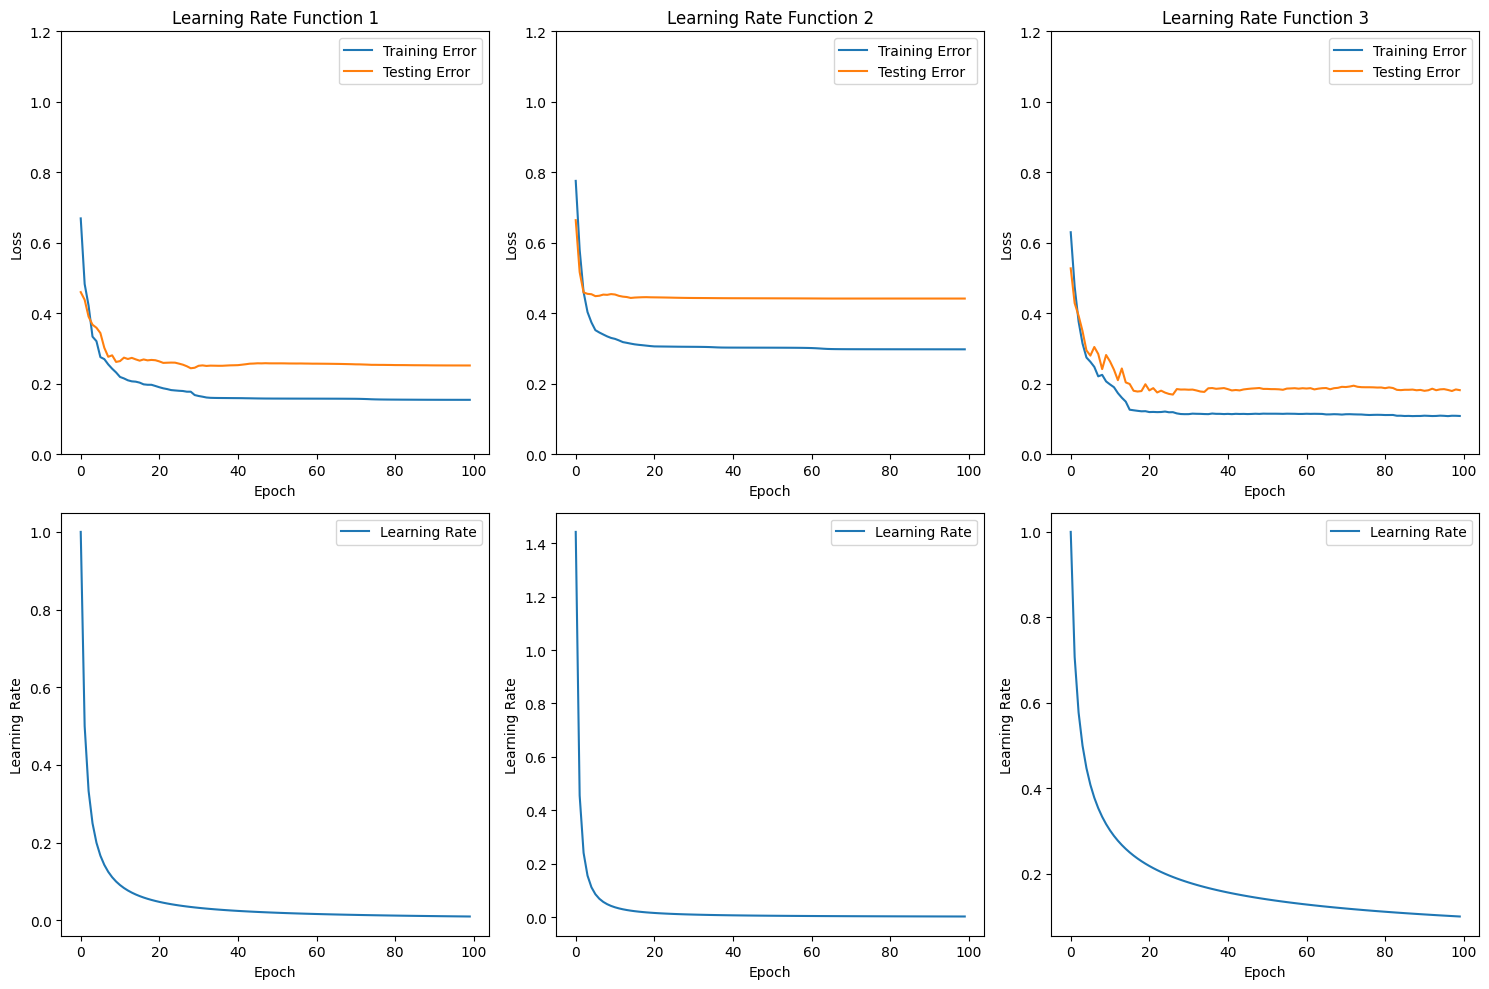

In [22]:
# Define learning rate functions
def learning_rate_simple(t):
    return 1 / (t + 1)  # Add 1 to avoid division by zero at t=0

def learning_rate_logarithmic(t):
    return 1 / ((t + 1) * np.log(t + 2))  # Add 1 to avoid division by zero at t=0, add 2 to avoid log(1)=0

def learning_rate_powerlaw(t):
    return (t + 1) ** -0.5  # Add 1 to avoid division by zero at t=0

names = ["Simple", "Logarithmic", "Power Law"]  # Names of the learning rate functions

learning_rates = [learning_rate_simple, learning_rate_logarithmic, learning_rate_powerlaw]  # Learning rate functions to test

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, learning_rate in enumerate(learning_rates):
    print(f"Running experiment with learning rate function {i+1}...")

    # Initialize network with specified parameters and learning rate
    network = Network(P=P, Q=Q, N=N, K=K, learning_rate=learning_rate)

    # Train the network and retrieve training and testing errors
    train_err, test_err, weights = network.train(t_max=100, train_set=train_set, test_set=test_set, verbose=False)

    # Set all y axis limits to the same value
    axs[0, i].set_ylim(0, 1.2)

    # Plot the training and testing errors over epochs
    axs[0, i].plot(train_err, label="Training Error")
    axs[0, i].plot(test_err, label="Testing Error")

    # Add a legend to the plot
    axs[0, i].legend()

    # Add labels to the x and y axes
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].set_title(f'Learning Rate Function {names[i]}')

    # Plot the learning rate over epochs
    learning_rates_over_epochs = [learning_rate(t) for t in range(100)]
    axs[1, i].plot(learning_rates_over_epochs, label="Learning Rate")

    # Add a legend to the plot
    axs[1, i].legend()

    # Add labels to the x and y axes
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_ylabel('Learning Rate')

# Display the plot
plt.tight_layout()
plt.show()